### Imports

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

### Settings

In [2]:
# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 5
random_seed = 1
learning_rate = 0.001
batch_size = 128
num_classes = 10

### Dataset

You can use your own custom dataset but for simplicity we will use torchvision's MNIST dataset

In [3]:
# Dataset
train_dataset = torchvision.datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(), # scales input images to 0-1 range
                               download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor()) # scales input images to 0-1 range

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

### Visualize

Make sure the data is loaded correctly

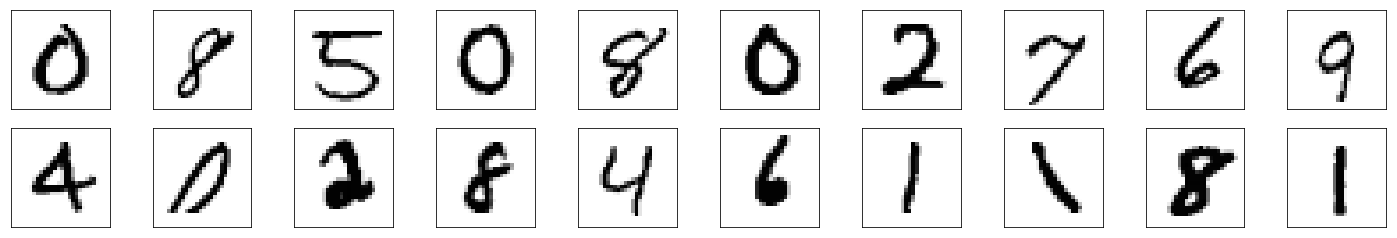

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


### Model

In [5]:
class ConvNet(torch.nn.Module):

    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        # calculate padding using formula p = (s(o-1) - w + k)/2
        
        # 28x28x1 => 28x28x4
        self.conv1 = nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) 
        # 28x28x4 => 14x14x4
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)                                        
        # 14x14x4 => 14x14x8
        self.conv2 = nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)             
        # 14x14x8 => 7x7x8                             
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)
        
        self.linear1 = nn.Linear(7*7*8, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        
        logits = self.linear1(out.view(-1, 7*7*8))
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

In [6]:
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        
        features = features.to(device)
        labels = labels.to(device)

        # Forward pass
        logits, probas = model(features)
        loss = criterion(logits, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, batch_idx+1, 
                     len(train_loader), loss.item()))
    

Epoch [1/5], Step [100/469], Loss: 0.5946
Epoch [1/5], Step [200/469], Loss: 0.5214
Epoch [1/5], Step [300/469], Loss: 0.3539
Epoch [1/5], Step [400/469], Loss: 0.3125
Epoch [2/5], Step [100/469], Loss: 0.2668
Epoch [2/5], Step [200/469], Loss: 0.3860
Epoch [2/5], Step [300/469], Loss: 0.2118
Epoch [2/5], Step [400/469], Loss: 0.1684
Epoch [3/5], Step [100/469], Loss: 0.1668
Epoch [3/5], Step [200/469], Loss: 0.3472
Epoch [3/5], Step [300/469], Loss: 0.2269
Epoch [3/5], Step [400/469], Loss: 0.1922
Epoch [4/5], Step [100/469], Loss: 0.1133
Epoch [4/5], Step [200/469], Loss: 0.1529
Epoch [4/5], Step [300/469], Loss: 0.1908
Epoch [4/5], Step [400/469], Loss: 0.1003
Epoch [5/5], Step [100/469], Loss: 0.0685
Epoch [5/5], Step [200/469], Loss: 0.0590
Epoch [5/5], Step [300/469], Loss: 0.0977
Epoch [5/5], Step [400/469], Loss: 0.1666


### Evaluaation

In [7]:
model = model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        logits, probas = model(features)
        _, predicted = torch.max(probas, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 97 %
